$$a_1 \equiv 1 - h_i^{guess}\partial_{x}F|_{\left(t_{i},x_{i}\right)}$$

$$a_2 \equiv 1 - h_i^{guess}\partial_{x}F|_{\left(t_{i}+h_{i}^{guess},x_{i}\right)}$$


$a_1$ and $a_2$ should be positive.

# if `_dxFx_tixi` is negative, then, no need to find `hi`, since it doesn't really matter; it is always stable .. may be not, think of a possibility for a bifurcation can happen

# Use linear treament just for hi stepsize control, and use pure Newton rapson method to find the proper $x_{i+1}$.

In [97]:
from numbers import Real

def get_stepsize(ti, xi, Fx, dxFx, hi_max,
                gamma = 0.8, hi_min = 0.005, forward=True):
    if not forward: raise NotImplementedError()
    _hi_guess = None
    _dxFx_tixi = dxFx(ti, xi)
    if _dxFx_tixi > 0: _hi_guess = min(gamma / _dxFx_tixi, hi_max)
    else: _hi_guess = hi_max
    assert (_hi_guess is not None) is isinstance(_hi_guess, Real)
    assert (1 - _hi_guess * _dxFx_tixi) > 0
    
    _a2 = None
    while _hi_guess > hi_min:
        _a2 = 1 - _hi_guess * dxFx(ti+_hi_guess, xi)
        if _a2 > 0: break
        _hi_guess *= gamma
    if (_hi_guess <= hi_min): raise Exception("hi_min reached - couldn't find good stepsize")
    _hi = _hi_guess
    
    return _hi

In [130]:
def iter_newton(ti, xi, hi, Fx, dxFx, thres=1e-10, N_itermax=10):
    _x = xi
    _t_next = ti + hi
    _x_converged = False
    for _i in range(N_itermax):
        _Gx = (_x - xi) - hi * Fx(_t_next, _x)
        _dxGx = 1.0 - hi * dxFx(_t_next, _x)
        assert _dxGx != 0
        _x_next = _x - _Gx / _dxGx
        _x_converged = abs(_x_next - _x) < thres
        print("_x_next - _x: {}".format(_x_next - _x))
        if _x_converged: break
        _x = _x_next
    if not _x_converged or (_i >= N_itermax - 1): raise Exception("convergence might have been failed")
    return _x_next

In [131]:
def Fx(t, x): return 3.0*x
def dxFx(t, x): return 3.0

t0, x0 = 0.2, -1.1

# try other fzero method also, such as bisection (for overcoming oscillation) .. and considering higher dimension, .. some general method -- consider the MATLAB etc. fzero algorithem

In [133]:
from scipy.optimize import root

In [136]:
def Gx(x): return (x - x0) - 0.2 * Fx(t0 + 0.2, x)

In [138]:
sol = root(Gx, x0)
sol.x

array([-2.75])

In [183]:
t_max = 5.0
t_list = [t0]
x_list = [x0]

while t_list[-1] < t_max:
    hi = get_stepsize(t_list[-1], x_list[-1], Fx, dxFx, hi_max=1.0, hi_min=0.0001)
#     hi = 0.5
    t_next = t_list[-1] + hi
    def Gx(x): return (x - x_list[-1]) - hi * Fx(t_next, x)
    sol = root(Gx, x_list[-1])
    x_next = sol.x
#     x_next = iter_newton(t_list[-1], x_list[-1], hi, Fx, dxFx)
    t_list.append(t_next), x_list.append(x_next)

In [184]:
hi

0.26666666666666666

In [156]:
import numpy as np

In [186]:
f_arr = x0 * np.exp(2.0 * (np.array(t_list) - t0))

In [187]:
import matplotlib.pyplot as plt

(-1000, 0)

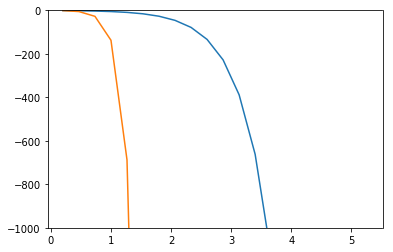

In [188]:
fig, ax = plt.subplots()

ax.plot(t_list, f_arr)
ax.plot(t_list, x_list)
ax.set_ylim(-1000,0)

In [189]:
# fig.savefig("implicit-euler-k-3-h-0.26-stepsize-controlled-test-0.png")

# ETC

In [71]:
x_list

[-1.1,
 -5.499999999999997,
 -27.49999999999999,
 -137.49999999999997,
 -687.5,
 -3437.5000000000005,
 -17187.500000000007,
 -85937.49999999999,
 -429687.5,
 -2148437.5000000005,
 -10742187.500000004,
 -53710937.50000003,
 -268554687.50000024]

In [55]:
from numbers import Real

def newton_iter(ti, xi, Fx, dxFx, hi_max,
                gamma = 0.8, hi_min = 0.005, forward=True):
    if not forward: raise NotImplementedError()
    _hi_guess = None
    _dxFx_tixi = dxFx(ti, xi)
    if _dxFx_tixi > 0: _hi_guess = gamma / _dxFx_tixi
    else: _hi_guess = hi_max
    assert (_hi_guess is not None) is isinstance(_hi_guess, Real)
    assert (1 - _hi_guess * _dxFx_tixi) > 0
    
    _a2 = None
    while _hi_guess > hi_min:
        _a2 = 1 - _hi_guess * dxFx(ti+_hi_guess, xi)
        print("_a2: ", _a2)
        if _a2 > 0: break
        _hi_guess *= gamma
    if (_hi_guess <= hi_min): raise Exception("hi_min reached - couldn't find good stepsize")
    _hi = _hi_guess
    
    _t_next = ti + _hi
    _x_next = xi + _hi * Fx(_t_next, xi) / _a2
    
    print(_a2, Fx(_t_next, xi))
    
    return _t_next, _x_next

In [56]:
def back_euler_iter(ti, xi, Fx, dxFx, hi_max,
                    thres = 1e-10, N_itermax=10, gamma = 0.8, hi_min = 0.005, forward=True):
    _ti, _xi, _t_next, _x_next = ti, xi, None, None
    _g_converged = False
    for _ in range(N_itermax):
        _t_next, _x_next = newton_iter(_ti, _xi, Fx, dxFx, hi_max=hi_max, 
                                     gamma=gamma, hi_min=hi_min, forward=forward)
        _g = (_x_next - xi) - (_t_next - ti) * Fx(_t_next, _x_next)
        print("(ti,xi)=({:.3f},{:.3f}) g: {}".format(ti, xi, _g))
        _g_converged = abs(_g) < thres
        if _g_converged: break
        _ti, _xi = _t_next, _x_next
    if not _g_converged or (i >= N_itermax - 1): raise Exception("convergence might have been failed")
    return _t_next, _x_next

In [57]:
def Fx(t, x): return 2.0*x
def dxFx(t, x): return 2.0

t0, x0 = 0.2, -1.1

In [58]:
t_max = 5.0
t_list = [t0]
x_list = [x0]

while t_list[-1] < t_max:
    ti, xi = back_euler_iter(t_list[-1], x_list[-1], Fx, dxFx, hi_max=0.2, N_itermax=10)
    t_list.append(ti), x_list.append(xi)

_a2:  0.19999999999999996
0.19999999999999996 -2.2
(ti,xi)=(0.200,-1.100) g: 0.0
_a2:  0.19999999999999996
0.19999999999999996 -11.000000000000004
(ti,xi)=(0.600,-5.500) g: -7.105427357601002e-15
_a2:  0.19999999999999996
0.19999999999999996 -55.00000000000003
(ti,xi)=(1.000,-27.500) g: -2.842170943040401e-14
_a2:  0.19999999999999996
0.19999999999999996 -275.0000000000002
(ti,xi)=(1.400,-137.500) g: -1.1368683772161603e-13
_a2:  0.19999999999999996
0.19999999999999996 -1375.0000000000014
(ti,xi)=(1.800,-687.500) g: -4.547473508864641e-13
_a2:  0.19999999999999996
0.19999999999999996 -6875.000000000009
(ti,xi)=(2.200,-3437.500) g: -3.637978807091713e-12
_a2:  0.19999999999999996
0.19999999999999996 -34375.00000000005
(ti,xi)=(2.600,-17187.500) g: -1.4551915228366852e-11
_a2:  0.19999999999999996
0.19999999999999996 -171875.00000000032
(ti,xi)=(3.000,-85937.500) g: -1.1641532182693481e-10
_a2:  0.19999999999999996
0.19999999999999996 -859375.0000000019
(ti,xi)=(3.000,-85937.500) g: 1375

Exception: convergence might have been failed

In [45]:
t_list

[0.2,
 0.6000000000000001,
 1.0,
 1.4,
 1.7999999999999998,
 2.1999999999999997,
 2.5999999999999996,
 2.9999999999999996]

In [46]:
x_list

[-1.1,
 -5.500000000000002,
 -27.500000000000014,
 -137.5000000000001,
 -687.5000000000007,
 -3437.5000000000045,
 -17187.500000000025,
 -85937.50000000016]

In [9]:
1 / (1 - 2 * 0.4) * xi

-5.500000000000002

In [19]:
newton_iter(t0, x0, Fx, dxFx, hi_max=0.2)

(0.6000000000000001, -5.500000000000002)

In [50]:
from numbers import Real

alpha = 0.8
gamma = 0.8
N_itermax_hi = 5  # [IMPROVEMENT] may be replaced by lower bound of hi_guess
N_itermax = 10
hi_guess_min = 0.005
g_thres = 1e-10  # [IMPROVEMENT] set it according to something
assert (0 < alpha) and (alpha < 1)
assert (0 < gamma) and (gamma < 1)

_ti, _xi = ti, xi

for _ in range(N_itermax):

    _dxFx_tixi = dxFx(_ti, _xi)
    if _dxFx_tixi == 0: raise NotImplementedError("waiting for second-order approx")
    _hi_guess = alpha / abs(_dxFx_tixi)

    # Find stepsize (`hi_guess`) which makes `a1` positive
    _a1 = None
    for _ in range(N_itermax_hi):
        _a1 = 1 - _hi_guess * _dxFx_tixi
        if _a1 > 0: break
        _hi_guess *= gamma
    assert (_a1 is not None) and isinstance(_a1, Real)
    if not (_a1 > 0): raise Exception("`N_itermax` exceeded")

    _a2 = None
    for _ in range(N_itermax_hi):
        _a2 = 1 - _hi_guess * dxFx(_ti + _hi_guess, _xi)
        if a2 > 0: break
        _hi_guess *= gamma
    assert (_a2 is not None) and isinstance(_a2, Real)
    if not (_a2 > 0): raise Exception("`N_itermax` exceeded")

    _hi = _hi_guess
    _t_next = _ti + _hi
    # [IMRROVMENT] dxFx has already been evaluated. Let's use that one
    _x_next = _xi + (_hi * Fx(_t_next, _xi)) / (1.0 - _hi * dxFx(_t_next, _xi))
    
    _g = (_x_next - _xi) - _hi * Fx(_t_next, _x_next)
    if abs(_g) < g_thres: break
    
    _xi, _ti = _x_next, _t_next

if not (abs(_g) < g_thres): raise Exception("Unexpected!")

In [51]:
_dxFx_tixi

2.0

In [52]:
xi

-1.1

In [53]:
_x_next

-5.500000000000002

In [54]:
_hi

0.4

In [55]:
_hi_guess

0.4

In [56]:
_ti

0.2

In [57]:
_t_next

0.6000000000000001

In [58]:
import numpy as np

In [60]:
-1.1 * np.exp(2*(_t_next - _ti))

-2.448095021341715